<h2>Loading, Optimizing & Preparing the data<h2/>

In [1]:
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps
#load train data
train_df=pd.read_json('data/train_cd.json')
images_train=[np.asarray(item) for item in train_df['images']]  #x_input is a list of arrays (since regular method will give us the data as list)

category_train=train_df['category'] 
category_train=category_train.replace(['cat','dog'],[0,1]) #changing dog and cat labels to binary presentation,that our y_input


# The sector in which i created the main dataset ill work with(train and test):

# filenames=listdir('data/dogs-vs-cats/train')
# category=[]
# images_test=[]
# for filename in filenames:
#     img=Image.open('data/dogs-vs-cats/train/'+filename)
#     img=img.convert('L')
#     img=img.resize((64,64),Image.ANTIALIAS)
#     img_test=np.asarray(img)/255.0
#     # animalType=filename.split('.')[0] #split returns a list of splitted strings, we need to string before the . which is the first one in the list
#     # category.append(animalType)
#     images_test.append(img_test)

In [6]:
df=pd.DataFrame({'images':images_test,'category':category})
df.to_json('train_cd.json')

In [25]:
#load test data
import numpy as np
import pandas as pd
test_df=pd.read_json('test_cd.json')
images_test=[np.asarray(item) for item in test_df['images']]  #x_input is a list of arrays (since regular method will give us the data as list)


In [26]:
# Reshaping our images matrices to 3d according to tensorFlow CNN *(Test)
for i in range(0,len(images_test)):
    images_test[i]=images_test[i].reshape(images_test[i].shape+(1,))

In [2]:
# Reshaping our images matrices to 3d according to tensorFlow CNN *(Train)
for i in range(0,len(images_train)):
    images_train[i]=images_train[i].reshape(images_train[i].shape+(1,))
images_train[0].shape

(64, 64, 1)

<h2>Creating our Model</h2>
<h4>- After many many model creations, tweakings and comparisons, the best model i got with the least epochs was this one: </h4>

In [3]:

from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
train_x=np.array(images_train)
#creating the training/testing set
x_train,x_test,y_train_,y_test= train_test_split(train_x,category_train,test_size=0.1,random_state=42)

In [26]:
import collections
collections.Counter(y_train_)

Counter({0: 11202, 1: 11298})

In [30]:
#3 CNN layers, and one Dropout before Dense layer.
#Ive got to conclusion that inserting dropout layer into cnn is not very benefical for this dataset, it starts good then falls quickly, but maybe it was needed more tweaking.
#Also, same thing with batchNormalizion.

model1=keras.Sequential()
model1.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(64,64,1)))
model1.add(layers.MaxPooling2D(2,2))

model1.add(layers.Conv2D(64, (3,3), activation='relu'))
model1.add(layers.MaxPooling2D(2,2))

model1.add(layers.Conv2D(128, (3,3), activation='relu'))
model1.add(layers.MaxPooling2D(2,2))

model1.add(layers.Flatten()) 
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(128,activation='relu'))
model1.add(layers.Dense(2,activation='softmax'))
model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4608)             

In [22]:
#A method of monitoring our model's progress, when it gets a decreasing val_accuracy for 2 epochs, lower the learning rate.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [31]:
model1.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
train_x_arr=np.array(x_train)
model1.fit(train_x_arr,y_train_,epochs=12,validation_data=(np.array(x_test),y_test),callbacks=[learning_rate_reduction])e

Train on 22500 samples, validate on 2500 samples
Epoch 1/12
22500/22500 [==============================] - 61s 3ms/sample - loss: 0.6174 - accuracy: 0.6464 - val_loss: 0.5347 - val_accuracy: 0.7296
Epoch 2/12
22500/22500 [==============================] - 63s 3ms/sample - loss: 0.4949 - accuracy: 0.7589 - val_loss: 0.4670 - val_accuracy: 0.7756
Epoch 3/12
22500/22500 [==============================] - 64s 3ms/sample - loss: 0.4444 - accuracy: 0.7904 - val_loss: 0.4704 - val_accuracy: 0.7764
Epoch 4/12
22500/22500 [==============================] - 60s 3ms/sample - loss: 0.4010 - accuracy: 0.8173 - val_loss: 0.3976 - val_accuracy: 0.8180
Epoch 5/12
22500/22500 [==============================] - 61s 3ms/sample - loss: 0.3710 - accuracy: 0.8312 - val_loss: 0.4169 - val_accuracy: 0.8088
Epoch 6/12
22500/22500 [==============================] - 64s 3ms/sample - loss: 0.3448 - accuracy: 0.8469 - val_loss: 0.3670 - val_accuracy: 0.8384
Epoch 7/12
22500/22500 [==============================] -

In [80]:
#Saving the model, 0.863 val accuracy, pretty good for 12 epochs.
model1.save('Model/BestModel') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Model/BestModel\assets


<h2>Visual showcase of the Predictions: </h2>

In [8]:
predictions= model1.predict(x_test)
predict_list=np.argmax(predictions, axis=-1)
predict_category=['cat' if x==0 else 'dog' for x in predict_list]


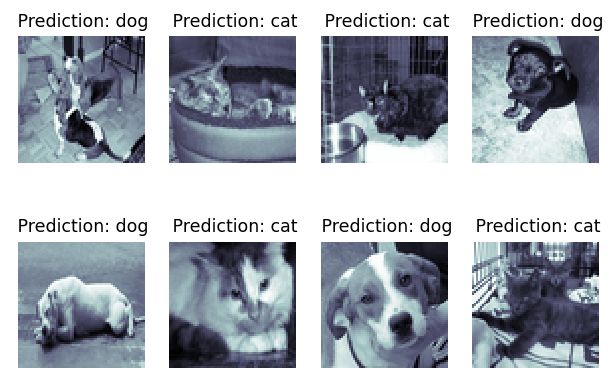

In [63]:
import matplotlib.pyplot as plt
import random
fig, axes = plt.subplots(2, 4)
fig.dpi=125
images_and_predictions=list(zip(x_test,predict_category))
random.shuffle(images_and_predictions) #shuffeling the list so each time we run the check we get different sets of images & predictions.
for ax, (image, prediction) in zip(axes[0,:], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image.reshape(64,64), interpolation='nearest',cmap=plt.cm.bone)
    ax.set_title(' Prediction: ' + prediction,fontsize=10)
for ax, (image, prediction) in zip(axes[1,:], images_and_predictions[4:8]):
    ax.set_axis_off()
    ax.imshow(image.reshape(64,64),cmap=plt.cm.bone, interpolation='nearest')
    ax.set_title(' Prediction: ' + prediction,fontsize=10)

<h3>Now a little tricky test, we take an image of a cat that looks like a dog, lets see the prediction:</h3>
<h5>(I took an image of a cat that looks like a dog, and tried to predict it)</h5>

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps
image4d=[]
imgtest=Image.open('data/dogcat.jpeg')
imgtest=imgtest.convert('L')
imgtest=imgtest.resize((64,64),Image.ANTIALIAS)
imgtest=np.asarray(imgtest)/255.0
imgtestre=imgtest.reshape(imgtest.shape+(1,))
imgtestre.shape
image4d.append(imgtestre)
image4d=np.asarray(image4d)
prediction1=model1.predict(image4d)


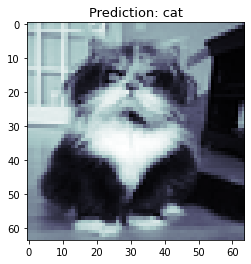

In [81]:
prediction1_label=np.argmax(prediction1, axis=-1)
if prediction1_label==1:
    prediction1_label='dog'
else:
    prediction1_label='cat'
plt.imshow(imgtest,cmap=plt.cm.bone)
plt.title("Prediction: "+prediction1_label,fontsize=13)
plt.show()
#Success!

<h3>Visual Evaluation</h3>

In [82]:
import tensorflow as tf
confusion=tf.math.confusion_matrix(labels=y_test,predictions=predict_list)


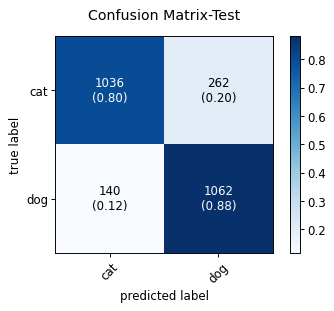

In [182]:
from mlxtend.plotting import plot_confusion_matrix
plot_confusion_matrix(conf_mat=confusion.numpy(), colorbar=True,cmap=plt.cm.Blues,show_absolute=True,show_normed=True,class_names=['cat','dog'])
plt.title("Confusion Matrix-Test")
plt.show()